In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import papermill
import umap

/home/marcelino.maita/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(papermill.__version__)

2.6.0


In [3]:
DATA_PATH ="../data"
path_lb_embb = os.path.join(DATA_PATH, "embbedings_khipu/lb_khipu_A.npy")
path_dataset = os.path.join(DATA_PATH, "spotify_dataset_sin_duplicados_4.csv")

# Para hacer pruebitas y luego mandarlo como sbatch
TESTING = False
_EMBEDDINGS = np.load(path_lb_embb)

if TESTING:
    _NROWS = 1000
    _EMBEDDINGS = _EMBEDDINGS[:1000]
    _EPHOCS = 1000
else:
    _NROWS = None
    _EPHOCS = 10000
    

df = pd.read_csv(path_dataset, nrows = _NROWS)
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})

X = _EMBEDDINGS

# Adding numeric cols
df['Loudness (db)'] = df['Loudness (db)'].astype(str).str.replace('db', '', regex=False)
df['Loudness (db)'] = pd.to_numeric(df['Loudness (db)'], errors='coerce')
df[['Danceability', 'Loudness (db)']] = df[['Danceability', 'Loudness (db)']].fillna(0)
X = np.concatenate([X, df[['Danceability', 'Loudness (db)']].to_numpy()], axis=1)



reducer = umap.UMAP(n_components=2, random_state=42)
X = reducer.fit_transform(X)

y = df['Explicit_binary']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

y_train = y_train.values.reshape(-1, 1).astype(np.float32)
y_test = y_test.values.reshape(-1, 1).astype(np.float32)


def seeRam():
    process = psutil.Process(os.getpid())
    print(f"RAM usada (MB): {process.memory_info().rss / (1024 * 1024):.2f}")

print(X.shape)
print(y.shape)
seeRam()

/home/marcelino.maita/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(108138, 2)
(108138,)
RAM usada (MB): 2302.70


In [4]:
# CODE HERE for backward pass

# f0, f1, f2
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)
        self.b = np.zeros((1, out_dim))
    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_output):
        self.grad_W = self.x.T @ grad_output
        self.grad_b = np.sum(grad_output, axis=0, keepdims=True)
        return grad_output @ self.W.T

# h0, h1, h2, ....
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask
    def backward(self, grad_output):
        return grad_output * self.mask

class Sigmoid:
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)

# error
class MSELoss:
    def forward(self, pred, target):
        self.diff = pred - target
        return np.mean(self.diff ** 2)
    def backward(self):
        return 2.0 * self.diff / self.diff.shape[0]

In [5]:
class MLP:
    def __init__(self, dims):
        self.layers = []
        for i in range(len(dims)-2):
            self.layers.append(Linear(dims[i], dims[i+1])) #fi
            self.layers.append(ReLU()) # hi

        self.layers.append(Linear(dims[-2], dims[-1]))
        self.layers.append(Sigmoid())

    # CODE HERE (forward, backward pass)
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

    def backward(self, grad):
        for l in reversed(self.layers):
            grad = l.backward(grad)

    @property
    def n_params(self):
        total = 0
        for l in self.layers:
            if isinstance(l, Linear):
                total += l.W.size + l.b.size
        return total

    def train(self, X, y, lr=0.1, epochs=10000, print_every=100):
      loss_fn = MSELoss()
      history = []
      for epoch in range(epochs):
          #forward
          pred = self.forward(X)
          loss = loss_fn.forward(pred, y)
          #backward
          grad = loss_fn.backward()
          self.backward(grad)

          # Descenso de la gradiente
          for layer in self.layers:
              if isinstance(layer, Linear):
                  layer.W -= lr * layer.grad_W
                  layer.b -= lr * layer.grad_b
          history.append(loss)
          if epoch % print_every == 0:
              print(f"Epoch {epoch}, Loss: {loss:.6f}")
      return history

    def train_batches(self, X, y, lr=0.1, epochs=10000, batch_size=32, print_every=100):
        loss_fn = MSELoss()
        history = []

        n = X.shape[0]
        for epoch in range(epochs):
            # Barajamos los datos al inicio de cada época
            perm = np.random.permutation(n)
            X_shuffled = X[perm]
            y_shuffled = y[perm]

            for i in range(0, n, batch_size):
                xb = X_shuffled[i:i+batch_size]
                yb = y_shuffled[i:i+batch_size]

                # Forward
                pred = self.forward(xb)
                loss = loss_fn.forward(pred, yb)

                # Backward
                grad = loss_fn.backward()
                self.backward(grad)

                # Actualización
                for layer in self.layers:
                    if isinstance(layer, Linear):
                        layer.W -= lr * layer.grad_W
                        layer.b -= lr * layer.grad_b

            pred_full = self.forward(X)
            epoch_loss = loss_fn.forward(pred_full, y)
            history.append(epoch_loss)

            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.6f}")

        return history


In [6]:
print(X_train.shape)
# y_train = Y.values.reshape(-1, 1).astype(np.float32) 
print(y_train.shape)

(86510, 2)
(86510, 1)


In [ ]:
mlp = MLP([2,3 ,4,8, 4,3, 1])
history= mlp.train(X_train, y_train, lr=0.5, epochs=_EPHOCS, print_every=1000)
print('Parámetros totales:', mlp.n_params)


Epoch 0, Loss: 0.370766


Epoch 1000, Loss: 0.170141


Epoch 2000, Loss: 0.172241


Epoch 3000, Loss: 0.170594


Epoch 4000, Loss: 0.170388


Epoch 5000, Loss: 0.170260


Epoch 6000, Loss: 0.170178


Epoch 7000, Loss: 0.170113


Epoch 8000, Loss: 0.170051


Epoch 9000, Loss: 0.170002


Parámetros totales: 17


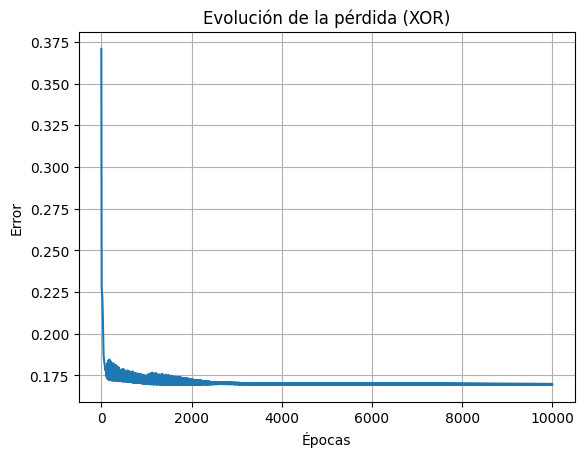

In [8]:
# Perdida
plt.figure()
plt.plot(history)
plt.xlabel("Épocas")
plt.ylabel("Error")
plt.title("Evolución de la pérdida (XOR)")
plt.grid(True)
plt.show()

In [9]:
# Pasando test a la red
pred_test = mlp.forward(X_test)

# Se hace la predicción
pred_labels = (pred_test >= 0.5).astype(int).flatten()
y_test_true = y_test.flatten()

# Calcular Accuracy y Reporte
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy en Test: {accuracy_score(y_test_true, pred_labels):.4f}")
print(classification_report(y_test_true, pred_labels))


Accuracy en Test: 0.7587


              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     16410
         1.0       0.00      0.00      0.00      5218

    accuracy                           0.76     21628
   macro avg       0.38      0.50      0.43     21628
weighted avg       0.58      0.76      0.65     21628



/home/marcelino.maita/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/marcelino.maita/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/marcelino.maita/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

[[16410     0]
 [ 5218     0]]


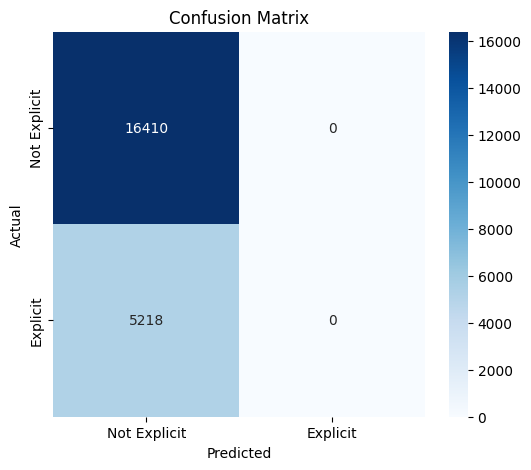

In [10]:
cm = confusion_matrix(y_test_true, pred_labels)

plt.figure(figsize=(6,5))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Explicit', 'Explicit'], yticklabels=['Not Explicit', 'Explicit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
        # Métricas
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

acc = accuracy_score(y_test_true, pred_labels)
prec = precision_score(y_test_true, pred_labels)
rec = recall_score(y_test_true, pred_labels)
f1 = f1_score(y_test_true, pred_labels)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

Accuracy:  0.7587
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000


/home/marcelino.maita/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


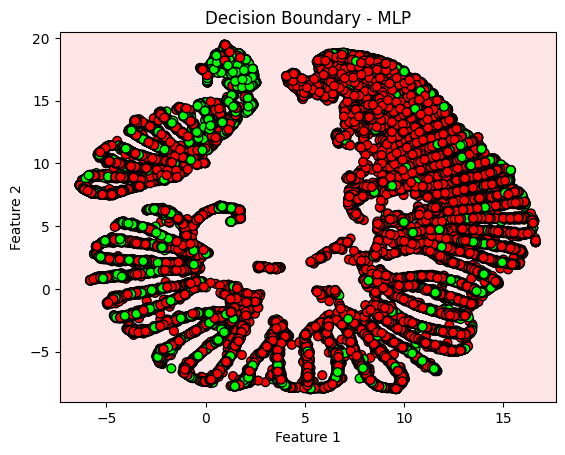

In [12]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import os
def plot_decision_boundary_mlp(model, X, y, title="Decision Boundary - MLP", save_path=None):
    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Predecir en la malla
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(grid)  # ahora devuelve probabilidad [0, 1]
    Z = Z.reshape(xx.shape)

    # Mapas de color
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Área coloreada
    plt.contourf(xx, yy, Z >= 0.5, alpha=0.3, cmap=cmap_light)

    # Línea límite donde prob = 0.5
    plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2)

    # Puntos reales
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=cmap_bold, edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Gráfico guardado en {save_path}")

    plt.show()


plot_decision_boundary_mlp(
    mlp, 
    X_train, 
    y_train, 
    title="Decision Boundary - MLP"
)